In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [5]:
from google.colab import files
uploaded = files.upload()


Saving supermarket_sales.csv to supermarket_sales.csv


In [6]:
df = pd.read_csv('supermarket_sales.csv')  # Adjust path if needed
df.head()


,invoice_id,branch,city,customer_type,gender_customer,product_line,unit_cost,quantity,5pct_markup,revenue,date,time,payment_method,cogs,gm_pct,gross_income,rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,01/05/19,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,03/08/19,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,03/03/19,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,02/08/19,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [11]:
# Convert date column
df['date'] = pd.to_datetime(df['date'])

# Optional: Rename columns to consistent naming (optional but cleaner)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Encode categorical variables
cat_cols = ['branch', 'city', 'customer_type', 'gender_customer', 'product_line', 'payment_method']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Feature Engineering
df_encoded['day_of_week'] = df_encoded['date'].dt.dayofweek
df_encoded['month'] = df_encoded['date'].dt.month

# Aggregate to daily revenue
daily_df = df_encoded.groupby('date').agg({
    'unit_cost': 'mean',
    'quantity': 'sum',
    '5pct_markup': 'mean',
    'revenue': 'sum',
    'cogs': 'sum',
    'gross_income': 'sum',
    'rating': 'mean',
    'day_of_week': 'first',
    'month': 'first',
})

# Include encoded categorical features — must be aggregated too (e.g., mode or mean)
encoded_cols = [col for col in df_encoded.columns if col.startswith(tuple(cat_cols))]

for col in encoded_cols:
    daily_df[col] = df_encoded.groupby('date')[col].mean()


In [12]:
X = daily_df.drop(['revenue', 'gross_income'], axis=1)
y = daily_df['revenue']  # or use gross_income if you prefer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))


Linear Regression R²: 1.0
RMSE: 5.250970108951385e-13


In [14]:
params = {'max_depth': [2, 4, 6, 8, 10]}
dt = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid=params, cv=3)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
print("Decision Tree Best Depth:", dt.best_params_)
print("R²:", r2_score(y_test, y_pred_dt))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))


Decision Tree Best Depth: {'max_depth': 6}
R²: 0.8518428078025772
RMSE: 472.38817649167356


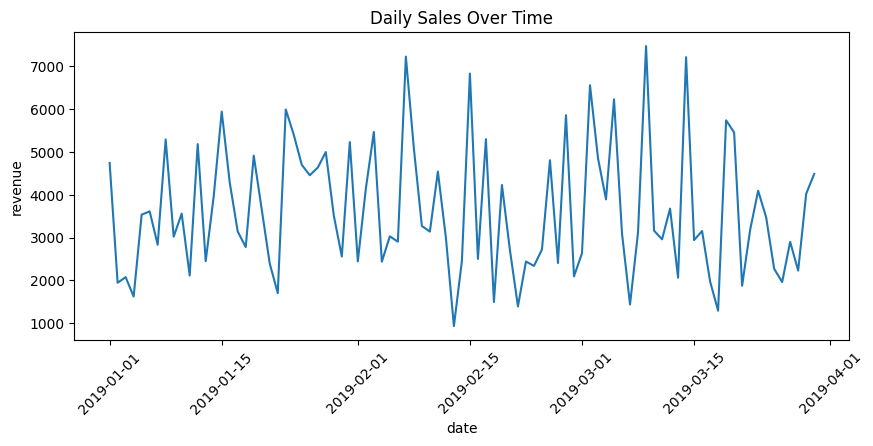

In [17]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=daily_df.index, y=daily_df['revenue'])
plt.title("Daily Sales Over Time")
plt.xticks(rotation=45)
plt.show()


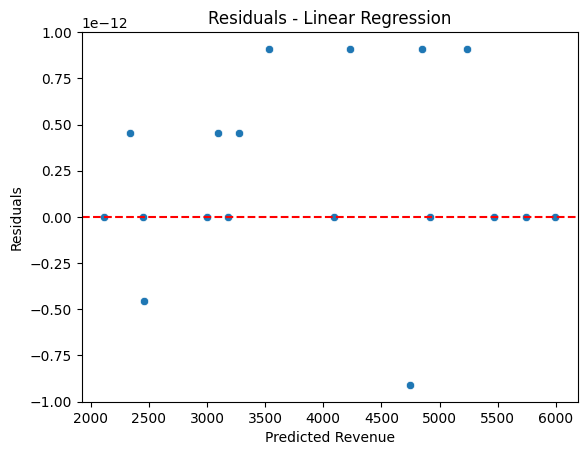

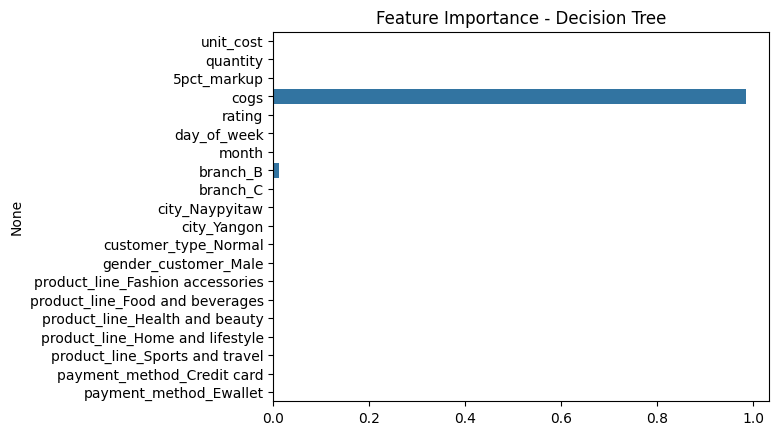

In [16]:
# Residual Plot
residuals = y_test - y_pred_lr
sns.scatterplot(x=y_pred_lr, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals - Linear Regression")
plt.xlabel("Predicted Revenue")
plt.ylabel("Residuals")
plt.show()

# Feature Importance (for Decision Tree)
feature_importance = dt.best_estimator_.feature_importances_
features = X.columns
sns.barplot(x=feature_importance, y=features)
plt.title("Feature Importance - Decision Tree")
plt.show()
